In [ ]:
# References:
# https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization

In [ ]:
!pip install tensorflow
!pip install tensorflow_hub

In [1]:
import requests
from PIL import Image
from io import BytesIO

import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras.utils as utils

print("TF Version: ", tf.__version__)
print("TF-Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.config.list_physical_devices('GPU'))

TF Version:  2.5.0
TF-Hub version:  0.12.0
Eager mode enabled:  True
GPU available:  []


In [2]:
original_image_cache = {}

def preprocess_image(image):
    image = np.array(image)
    # reshape into shape [batch_size, height, width, num_channels]
    img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    image = tf.image.convert_image_dtype(img_reshaped, tf.float32)
    return image

def load_image_from_url(img_url):
    """Returns an image with shape [1, height, width, num_channels]."""
    user_agent = {'User-agent': 'Colab Sample (https://tensorflow.org)'}
    response = requests.get(img_url, headers=user_agent)
    image = Image.open(BytesIO(response.content))
    image = preprocess_image(image)
    return image

def load_image(image_url, image_size=256, dynamic_size=False, max_dynamic_size=512):
    """Loads and preprocesses images."""
    # Cache image file locally.
    if image_url in original_image_cache:
        img = original_image_cache[image_url]
    elif image_url.startswith('https://'):
        img = load_image_from_url(image_url)
    else:
        fd = tf.io.gfile.GFile(image_url, 'rb')
        img = preprocess_image(Image.open(fd))
        original_image_cache[image_url] = img
        # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
        img_raw = img
    if tf.reduce_max(img) > 1.0:
        img = img / 255.
    if len(img.shape) == 3:
        img = tf.stack([img, img, img], axis=-1)
    if not dynamic_size:
        img = tf.image.resize_with_pad(img, image_size, image_size)
    elif img.shape[1] > max_dynamic_size or img.shape[2] > max_dynamic_size:
        img = tf.image.resize_with_pad(img, max_dynamic_size, max_dynamic_size)
    return img, img_raw

def show_image(image, title=''):
    image_size = image.shape[1]
    w = (image_size * 6) // 320
    plt.figure(figsize=(w, w))
    plt.imshow(image[0], aspect='equal')
    plt.axis('off')
    plt.title(title)
    plt.show()
    
    
# @title Define image loading and visualization functions  { display-mode: "form" }

def crop_center(image):
    """Returns a cropped square image."""
    shape = image.shape
    new_shape = min(shape[1], shape[2])
    offset_y = max(shape[1] - shape[2], 0) // 2
    offset_x = max(shape[2] - shape[1], 0) // 2
    image = tf.image.crop_to_bounding_box(image, offset_y, offset_x, new_shape, new_shape)
    return image

@functools.lru_cache(maxsize=None)
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
    """Loads and preprocesses images."""
    # Cache image file locally.
    image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
    # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
    img = tf.io.decode_image(
    tf.io.read_file(image_path),
    channels=3, dtype=tf.float32)[tf.newaxis, ...]
    img = crop_center(img)
    img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
    return img

def show_n(images, titles=('',)):
    n = len(images)
    image_sizes = [image.shape[1] for image in images]
    w = (image_sizes[0] * 6) // 320
    plt.figure(figsize=(w * n, w))
    gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
    for i in range(n):
        plt.subplot(gs[i])
        plt.imshow(images[i][0], aspect='equal')
        plt.axis('off')
        plt.title(titles[i] if len(titles) > i else '')
        plt.show()

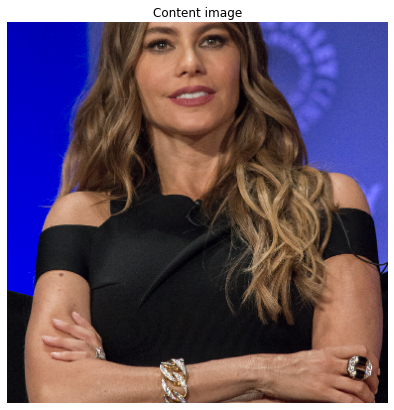

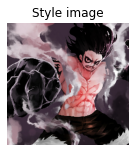

In [46]:
# @title Load example images  { display-mode: "form" }

content_image_url = 'https://upload.wikimedia.org/wikipedia/commons/f/fa/Sof%C3%ADa_Vergara_at_2015_PaleyFest.jpg'  # @param {type:"string"}
style_image_url = 'https://upload.wikimedia.org/wikipedia/commons/4/45/Snakeman_.jpg'  # @param {type:"string"}
output_image_size = 384  # @param {type:"integer"}

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the 
# recommended image size for the style image (though, other sizes work as 
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_image(content_image_url, content_img_size)
style_image = load_image(style_image_url, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[1,1], strides=[1,1], padding='SAME')
show_n([content_image, style_image], ['Content image', 'Style image'])

In [4]:
# Load TF-Hub module.

# Download this on production
hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

In [47]:
# Stylize content image with given style image.
# This is pretty fast within a few milliseconds on a GPU.

outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

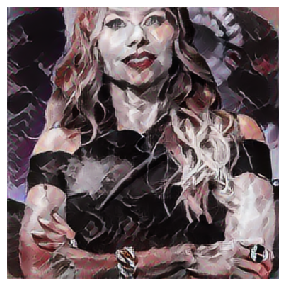

In [49]:
plt.figure(figsize = (5,5))
plt.imshow(stylized_image[0], aspect='equal', interpolation='nearest')
plt.axis('off')
plt.show()

In [218]:
#TODO: Clustering picture to make it more stable
#TODO: Apply many styles to one picture by keep feeding output image to the next style in the styles array